In [1]:
import os, sys
import json
import numpy as np
import subprocess
import glob
import pandas as pd
from tqdm import tqdm

In [2]:
sys.path.insert(0, "../")
import utils.data_util as data_util

In [3]:
# change "results" to "/volume1/coinse/Arachne/results/rev"
root_resultdir = "/Users/jeongju.sohn/workdir/arachne/arachne/results/rq3/on_test"
#root_resultdir = "/Users/jeongju.sohn/workdir/arachne/arachne/results/rq3/on_train"
# change "indices" to "/volume1/coinse/Arachne/indices"
indexdir = "/Users/jeongju.sohn/workdir/arachne/arachne/indices"

pred_dirs = {'fashion_mnist':os.path.join(root_resultdir, "fm/pred"),
             'cifar10':os.path.join(root_resultdir, "cm/pred"),
             'GTSRB':os.path.join(root_resultdir, "gtsrb/pred")}

test_data_init_pred_file = {
    'fashion_mnist':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/fm/test/fashion_mnist.init_pred.indices.csv",
    'cifar10':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/cm/test/cifar10.init_pred.indices.csv",
    'GTSRB':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/GTSRB/rq1/wo_hist/test/GTSRB.init_pred.indices.csv"}

iter_indices = np.arange(30)

In [4]:
def get_predition_file(which, iter_idx, is_used = False):
    """
    return prediction list of files 
    e.g., pred.misclf-rq3.27-8-6.eval.pkl
    """
    pred_dir = pred_dirs[which]
    postfix = "eval" if not is_used else "train"
    found = glob.glob(os.path.join(pred_dir, "pred.misclf-*.{}-*.{}.pkl".format(iter_idx, postfix)))
    assert len(found) == 1, found
    pred_file = found[0]
    return pred_file

In [46]:
def get_top_n_misclf_types(which, iter_indices = np.arange(30), is_used = False):
    """
    """
    import re
    pred_dir = pred_dirs[which]
    postfix = "eval" if not is_used else "train"
    misclf_types = {}
    for iter_idx in iter_indices:
        found = glob.glob(os.path.join(pred_dir, "pred.misclf-*.{}-*.{}.pkl".format(iter_idx, postfix)))
        assert len(found) == 1, found
        pred_file = found[0]
        pred_file = os.path.basename(pred_file)
        
        pat = "pred.misclf-.*.{}-([0-9]+)-([0-9]+).*.pkl".format(iter_idx)
        matched = re.match(pat, pred_file)
        assert bool(matched), pat
        
        true_label, pred_label = matched.groups()
        true_label = int(true_label); pred_label = int(pred_label)
        
        misclf_types[iter_idx] = (true_label, pred_label)
    
    return misclf_types

In [49]:
misclf_types = {}
for data_type in ['fashion_mnist', 'cifar10', 'GTSRB']:
    misclf_types[data_type] = get_top_n_misclf_types(data_type, is_used = True)

In [5]:
def get_prediction(which, iter_indices = np.arange(30)):
    """
    """
    used_init_pred = pd.read_csv(test_data_init_pred_file[which])
    eval_init_pred = pd.read_csv(test_data_init_pred_file[which])

    used_aft_pred = {}; eval_aft_pred = {}
    for iter_idx in tqdm(iter_indices):
        used_aft_pred_file = get_predition_file(which, iter_idx, is_used = True)
        used_aft_df = pd.read_pickle(used_aft_pred_file)
        used_aft_pred[iter_idx] = used_aft_df
        
        eval_aft_pred_file = get_predition_file(which, iter_idx, is_used = False)
        eval_aft_df = pd.read_pickle(eval_aft_pred_file)
        eval_aft_pred[iter_idx] = eval_aft_df
    
    
    return {'init':{'used':used_init_pred, 'eval':eval_init_pred}, 
           'after':{'used':used_aft_pred, 'eval':eval_aft_pred}}

In [7]:
def cnt_misclf(pred_df, true_cltype, pred_cltype):
    """
    """
    num_fault = np.sum((pred_df.true == true_cltype) & (pred_df.pred == pred_cltype))
    return num_fault

In [8]:
def get_target_misclf_pred(true_label, pred_label, pred_df):
    """
    return the predictions for the top_n most frequenet misclassifications. 
    prediction_df: contain the entire prediction result
    """
    cnt_init_misclf = np.sum((pred_df.true == true_label) & (pred_df.pred == pred_label))
    cnt_aft_misclf = np.sum((pred_df.true == true_label) & (pred_df.new_pred == pred_label))
    
    return {'init':cnt_init_misclf, 'aft':cnt_aft_misclf}

# Evaluation

## Getting Results

### Fashion-MNIST

In [51]:
which = 'fashion_mnist'
fm_predictions = get_prediction(which, iter_indices = np.arange(30))

fm_misclf_cnts = {'used':[], 'eval':[]}
fm_misclf_types = {}
for iter_idx in tqdm(np.arange(30)):
    top_n = iter_idx
    #misclf_key,_,_,_ = data_util.gen_data_for_rq3(test_data_init_pred_file[which], top_n, idx = 0)
    misclf_key = misclf_types[which][iter_idx]
    
    true_label, pred_label = misclf_key
    fm_misclf_types[iter_idx] = misclf_key
    
    # logging
    print ("We are targeting ({}): {}(true) -> {}(predicted)".format(iter_idx, true_label, pred_label))
    
    # used
    used_cnts = get_target_misclf_pred(true_label, pred_label, fm_predictions['after']['used'][top_n])
    
    # eval
    eval_cnts = get_target_misclf_pred(true_label, pred_label, fm_predictions['after']['eval'][top_n])
    
    print ("\tused: {} -> {}".format(used_cnts['init'], used_cnts['aft']))
    print ("\teval: {} -> {}".format(eval_cnts['init'], eval_cnts['aft']))
    
    fm_misclf_cnts['used'].append([used_cnts['init'], used_cnts['aft']])
    fm_misclf_cnts['eval'].append([eval_cnts['init'], eval_cnts['aft']])
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 416.46it/s]

We are targeting (0): 6(true) -> 0(predicted)
	used: 65 -> 16
	eval: 64 -> 26
We are targeting (1): 6(true) -> 2(predicted)
	used: 47 -> 17
	eval: 47 -> 27
We are targeting (2): 2(true) -> 4(predicted)
	used: 43 -> 5
	eval: 43 -> 12
We are targeting (3): 0(true) -> 6(predicted)
	used: 42 -> 15
	eval: 42 -> 11
We are targeting (4): 4(true) -> 2(predicted)
	used: 38 -> 10
	eval: 37 -> 14
We are targeting (5): 6(true) -> 4(predicted)
	used: 35 -> 17
	eval: 34 -> 21
We are targeting (6): 2(true) -> 6(predicted)
	used: 31 -> 10
	eval: 31 -> 13
We are targeting (7): 4(true) -> 6(predicted)
	used: 24 -> 8
	eval: 24 -> 10
We are targeting (8): 9(true) -> 7(predicted)
	used: 20 -> 4
	eval: 20 -> 9
We are targeting (9): 6(true) -> 3(predicted)
	used: 16 -> 10
	eval: 16 -> 10
We are targeting (10): 3(true) -> 6(predicted)
	used: 16 -> 10
	eval: 15 -> 8
We are targeting (11): 0(true) -> 3(predicted)
	used: 15 -> 8
	eval: 14 -> 3
We are targeting (12): 4(true) -> 3(predicted)
	used: 13 -> 4
	eval: 

### CIFAR-10

In [52]:
which = 'cifar10'
c10_predictions = get_prediction(which, iter_indices = np.arange(30))

c10_misclf_cnts = {'used':[], 'eval':[]}; 
c10_misclf_types = {}

for iter_idx in tqdm(np.arange(30)):
    top_n = iter_idx
    #misclf_key,_,_,_ = data_util.gen_data_for_rq3(test_data_init_pred_file[which], top_n, idx = 0) 
    misclf_key = misclf_types[which][iter_idx]
    true_label, pred_label = misclf_key
    c10_misclf_types[iter_idx] = misclf_key
    
    # logging
    print ("We are targeting ({}): {}(true) -> {}(predicted)".format(iter_idx, true_label, pred_label))
    
    # used
    used_cnts = get_target_misclf_pred(true_label, pred_label, c10_predictions['after']['used'][top_n])
    
    # eval
    eval_cnts = get_target_misclf_pred(true_label, pred_label, c10_predictions['after']['eval'][top_n])
    
    print ("\tused: {} -> {}".format(used_cnts['init'], used_cnts['aft']))
    print ("\teval: {} -> {}".format(eval_cnts['init'], eval_cnts['aft']))
    
    c10_misclf_cnts['used'].append([used_cnts['init'], used_cnts['aft']])
    c10_misclf_cnts['eval'].append([eval_cnts['init'], eval_cnts['aft']])
     

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 475.67it/s]

We are targeting (0): 3(true) -> 5(predicted)
	used: 104 -> 18
	eval: 104 -> 30
We are targeting (1): 5(true) -> 3(predicted)
	used: 68 -> 33
	eval: 68 -> 29
We are targeting (2): 2(true) -> 6(predicted)
	used: 53 -> 25
	eval: 53 -> 28
We are targeting (3): 2(true) -> 4(predicted)
	used: 52 -> 18
	eval: 52 -> 16
We are targeting (4): 2(true) -> 5(predicted)
	used: 50 -> 20
	eval: 49 -> 25
We are targeting (5): 3(true) -> 6(predicted)
	used: 50 -> 23
	eval: 49 -> 24
We are targeting (6): 1(true) -> 9(predicted)
	used: 45 -> 10
	eval: 45 -> 23
We are targeting (7): 4(true) -> 6(predicted)
	used: 41 -> 19
	eval: 40 -> 20
We are targeting (8): 9(true) -> 1(predicted)
	used: 41 -> 10
	eval: 41 -> 9
We are targeting (9): 0(true) -> 8(predicted)
	used: 41 -> 13
	eval: 40 -> 17
We are targeting (10): 2(true) -> 0(predicted)
	used: 40 -> 12
	eval: 40 -> 15
We are targeting (11): 4(true) -> 7(predicted)
	used: 39 -> 8
	eval: 39 -> 8
We are targeting (12): 3(true) -> 4(predicted)
	used: 38 -> 29


### GTSBR

Note: it could be interesting to investigate which types of misclassifications have been repaired the most by patches.
Unlike Fashion Mnist and CIFAR-10, we might get explainable results or interesting/applicable results here, beacause, for GTSBR, the trend of the repair rate for specific type of misclassification does not follow the frequency rate: e.g., for 6(true) -> 42(predicted), almost all misclassifications with this type were fixed, whereas 2(true) -> 3(predicted), none of them are fixed. 

Seems like we can do some case study here. For example, 18 (true) -> 19 (pred), which means predicting other danger sign to left reverse bend sign, 
or 25(true) -> 20(predicte), which means construction sign to right road ..? 

In [53]:
which = 'GTSRB'
gtsrb_predictions = get_prediction(which, iter_indices = np.arange(30))

gtsrb_misclf_cnts = {'used':[], 'eval':[]}
gtsrb_misclf_types = {}
for iter_idx in tqdm(np.arange(30)):
    top_n = iter_idx
    #misclf_key,_,_,_ = data_util.gen_data_for_rq3(test_data_init_pred_file[which], top_n, idx = 0) 
    misclf_key = misclf_types[which][iter_idx]
    true_label, pred_label = misclf_key
    gtsrb_misclf_types[iter_idx] = misclf_key
    
    # logging
    print ("We are targeting ({}): {}(true) -> {}(predicted)".format(iter_idx, true_label, pred_label))
    
    # used
    used_cnts = get_target_misclf_pred(true_label, pred_label, gtsrb_predictions['after']['used'][top_n])
    
    # eval
    eval_cnts = get_target_misclf_pred(true_label, pred_label, gtsrb_predictions['after']['eval'][top_n])
    
    print ("\tused: {} -> {}".format(used_cnts['init'], used_cnts['aft']))
    print ("\teval: {} -> {}".format(eval_cnts['init'], eval_cnts['aft']))
    
    gtsrb_misclf_cnts['used'].append([used_cnts['init'], used_cnts['aft']])
    gtsrb_misclf_cnts['eval'].append([eval_cnts['init'], eval_cnts['aft']])
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 426.57it/s]

We are targeting (0): 7(true) -> 8(predicted)
	used: 17 -> 8
	eval: 17 -> 9
We are targeting (1): 41(true) -> 9(predicted)
	used: 16 -> 13
	eval: 16 -> 12
We are targeting (2): 30(true) -> 31(predicted)
	used: 14 -> 7
	eval: 13 -> 6
We are targeting (3): 23(true) -> 31(predicted)
	used: 13 -> 0
	eval: 12 -> 1
We are targeting (4): 17(true) -> 38(predicted)
	used: 13 -> 14
	eval: 13 -> 15
We are targeting (5): 6(true) -> 5(predicted)
	used: 12 -> 1
	eval: 11 -> 1
We are targeting (6): 18(true) -> 21(predicted)
	used: 11 -> 2
	eval: 11 -> 1
We are targeting (7): 19(true) -> 31(predicted)
	used: 11 -> 10
	eval: 11 -> 11
We are targeting (8): 6(true) -> 42(predicted)
	used: 11 -> 1
	eval: 10 -> 0
We are targeting (9): 2(true) -> 3(predicted)
	used: 11 -> 11
	eval: 11 -> 11
We are targeting (10): 21(true) -> 42(predicted)
	used: 11 -> 5
	eval: 11 -> 5
We are targeting (11): 8(true) -> 5(predicted)
	used: 10 -> 8
	eval: 10 -> 9
We are targeting (12): 17(true) -> 14(predicted)
	used: 10 -> 1


## Plot

In [161]:
def plot_generalisability_in_one(changes, 
                                 misclf_keys_per_data,  
                                 iter_indices = np.arange(30), 
                                 top_n = 10, figsize = (8,6),
                                 title = None, filepath = None):
    """
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig = plt.figure(figsize = figsize)
    axes = []
    for i in range(1,7):
        #ax = fig.add_subplot(1,4,i)
        ax = fig.add_subplot(3,2,i)
        axes.append(ax)
        
    
    colors = ['blue', 'navy', 'forestgreen', 'darkgreen', 'goldenrod', 'darkgoldenrod']
    data_types = [('fm','used'), ('fm','eval'),
            ('c10','used'), ('c10','eval'),
            ('gtsrb','used'),('gtsrb','eval')]
    
    for i, data_type in enumerate(data_types):
        misclf_keys = misclf_keys_per_data[data_type[0]]
        
        ax = axes[i]
        curr_changes = changes[data_type[0]][data_type[1]]
        color = colors[i]
        
        max_v = np.max(curr_changes[:top_n])
        min_v = np.min(curr_changes[:top_n])
    
        ax.set_xlim(0, len(iter_indices) + 0.5)
        space = (max_v - 0)/30
    
        ax.set_ylim(np.min(min_v - space * 2,0), max_v + space * 2)
    
        iter_indices = np.asarray(iter_indices)
        xs = iter_indices + 0.5
        
        width = 0.7; height = (max_v-0)/30       
        
        for j,(cnt_init, cnt_aft) in enumerate(curr_changes[:top_n]):
            rect_1 = patches.Rectangle(xy=(xs[j], cnt_init), edgecolor = color, facecolor = color,
                                   alpha = 0.3, width=width, height=height, fill = True)

            rect_2 = patches.Rectangle(xy=(xs[j], cnt_aft),edgecolor = color, facecolor = color,
                                   width=width, height=height, fill = True)
        
            ax.add_patch(rect_1); ax.add_patch(rect_2)
            
            dx = 0; dy = np.min(cnt_aft - cnt_init + height*2, 0)
            if dy < 0:
                ax.arrow(xs[j]+width/2, cnt_init, dx, dy, head_width=width/4, head_length=height, fc='k', ec='k')
            else:
                dy = np.min(cnt_aft - cnt_init + height)
                ax.arrow(xs[j]+width/2, cnt_init, dx, dy, head_width=0, head_length=0, fc='k', ec='k')

        ax.set_xticks(xs + width/2)
        ftypes = [str(misclf_keys[iter_idx][0]) + r'$\rightarrow$' + str(misclf_keys[iter_idx][1]) 
                for iter_idx in np.arange(top_n)]
        ax.set_xticklabels(ftypes, rotation = 90,fontsize = 16)
        #ax.set_xticklabels(iter_indices)
    
        minor_ticks = xs -1 + width + width/4
        ax.set_xticks(minor_ticks, minor=True)
    
        #ax.set_xlabel("Top {} faults".format(top_n), fontsize = 18)
        if i == 0:
            ax.set_ylabel("# of faults", fontsize = 18)
    
        ax.tick_params(axis='both', which='major', labelsize=16)
    
        ax.grid(which='minor', axis='x', zorder = 100)
        ax.grid(which='major', axis='y', zorder = 100)
        #plt.rc('axes', axisbelow=True)

        if data_type[0] == 'c10':
            sub_title = "CIFAR-10 ({})".format(data_type[1])
        elif data_type[0] == 'fm':
            sub_title = "Fashion MNIST ({})".format(data_type[1])
        else:
            sub_title = "GTSRB ({})".format(data_type[1])
            
        ax.set_title(sub_title, fontsize = 18)
    
    plt.tight_layout()
    if filepath is not None:
        plt.savefig(filepath)
    
    plt.show()
    

In [204]:
def plot_generalisability(changes, 
                                 misclf_keys_per_data,  
                                 iter_indices = np.arange(30), 
                                 top_n = 10, figsize = (8,6),
                                 title = None, filepaths = None):
    """
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    colors = ['blue', 'navy', 'forestgreen', 'darkgreen', 'goldenrod', 'darkgoldenrod']
    data_types = [('fm','used'), ('fm','eval'),
            ('c10','used'), ('c10','eval'),
            ('gtsrb','used'),('gtsrb','eval')]
    
    for i, data_type in enumerate(data_types):
        fig = plt.figure(figsize = figsize)
        ax = fig.add_subplot(111)
        
        misclf_keys = misclf_keys_per_data[data_type[0]]
        curr_changes = changes[data_type[0]][data_type[1]]
        color = colors[i]
        
        max_v = np.max(curr_changes[:top_n])
        min_v = np.min(curr_changes[:top_n])
    
        ax.set_xlim(0, len(iter_indices) + 0.5)
        space = (max_v - 0)/30
    
        ax.set_ylim(np.min(min_v - space * 2,0), max_v + space * 2)
    
        iter_indices = np.asarray(iter_indices)
        xs = iter_indices + 0.5
        
        width = 0.7; height = (max_v-0)/30       
        
        for j,(cnt_init, cnt_aft) in enumerate(curr_changes[:top_n]):
            rect_1 = patches.Rectangle(xy=(xs[j], cnt_init), edgecolor = color, facecolor = color,
                                   alpha = 0.3, width=width, height=height, fill = True)

            rect_2 = patches.Rectangle(xy=(xs[j], cnt_aft),edgecolor = color, facecolor = color,
                                   width=width, height=height, fill = True)
        
            ax.add_patch(rect_1); ax.add_patch(rect_2)
            
            dx = 0; dy = np.min(cnt_aft - cnt_init + height*2, 0)
            if dy < 0:
                ax.arrow(xs[j]+width/2, cnt_init, dx, dy, head_width=width/4, head_length=height, fc='k', ec='k')
            else:
                dy = np.min(cnt_aft - cnt_init + height)
                ax.arrow(xs[j]+width/2, cnt_init, dx, dy, head_width=0, head_length=0, fc='k', ec='k')

        ax.set_xticks(xs + width/2)
        ftypes = [str(misclf_keys[iter_idx][0]) + r'$\rightarrow$' + str(misclf_keys[iter_idx][1]) 
                for iter_idx in np.arange(top_n)]
        
        ax.set_xticklabels(ftypes) #, fontsize = 10)
        #ax.set_xticklabels(iter_indices)
    
        minor_ticks = xs -1 + width + width/4
        ax.set_xticks(minor_ticks, minor=True)
    
        #ax.set_xlabel("Top {} faults".format(top_n), fontsize = 18)
        ax.set_ylabel("# of faults", fontsize = 18)
    
        ax.tick_params(axis='both', which='major', labelsize=12)
    
        ax.grid(which='minor', axis='x', zorder = 100)
        ax.grid(which='major', axis='y', zorder = 100)
        #plt.rc('axes', axisbelow=True)

        if data_type[0] == 'c10':
            sub_title = "CIFAR-10 ({})".format(data_type[1])
        elif data_type[0] == 'fm':
            sub_title = "Fashion MNIST ({})".format(data_type[1])
        else:
            sub_title = "GTSRB ({})".format(data_type[1])
            
        #ax.set_title(sub_title, fontsize = 18)
    
        plt.tight_layout()
        if filepaths is not None:
            plt.savefig(filepaths[data_type[0]][data_type[1]])
    

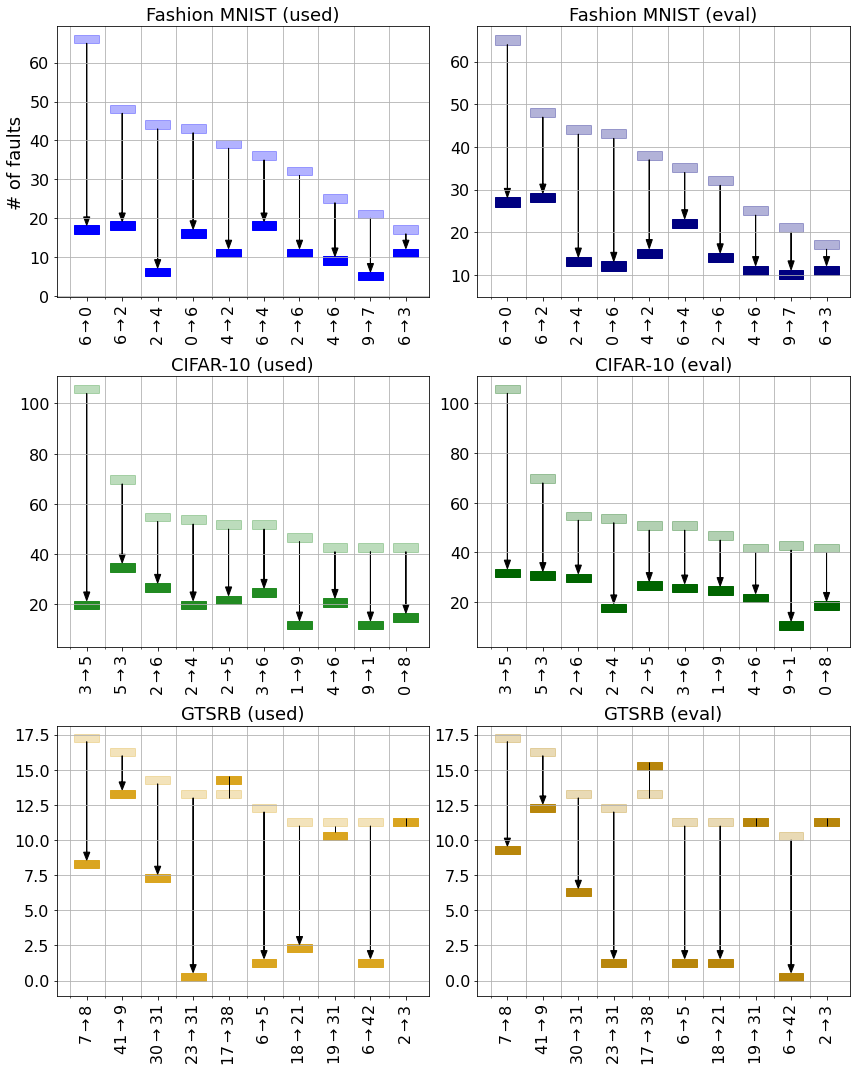

In [162]:
changes_per_proj = {'c10':c10_misclf_cnts, 
                    'fm':fm_misclf_cnts, 
                    'gtsrb':gtsrb_misclf_cnts}

misclf_keys_per_proj = {'c10':c10_misclf_types, 'fm':fm_misclf_types, 'gtsrb':gtsrb_misclf_types}

filepath = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq3/chg_in_all.pdf"
plot_generalisability_in_one(
    changes_per_proj, 
    misclf_keys_per_proj,  
    iter_indices = np.arange(10), # for top 10 (we have 30 in total, though)
    top_n = 10, figsize = (12,15), 
    title = None, filepath = filepath)

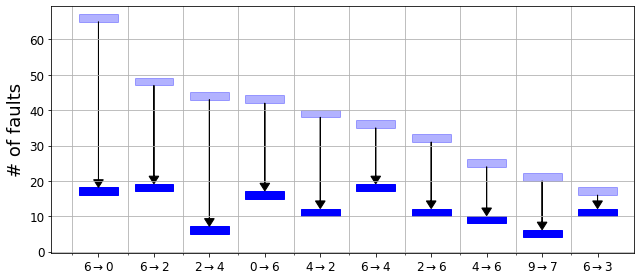

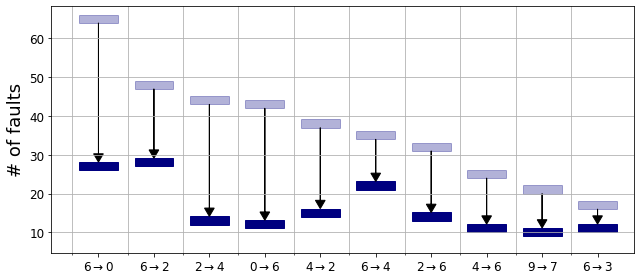

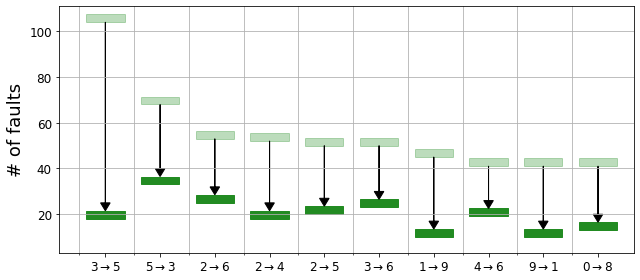

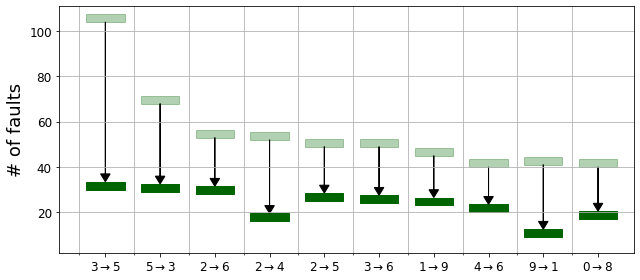

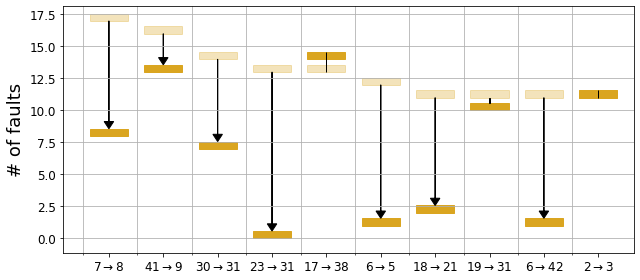

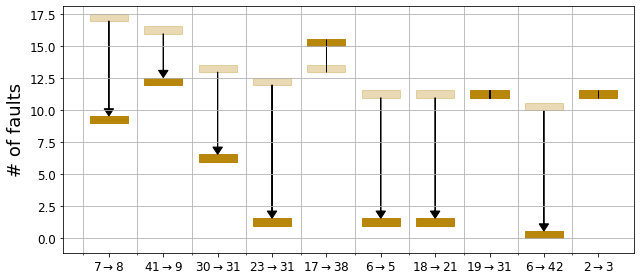

In [205]:
dest = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq3"

filepaths = {}
for k in changes_per_proj.keys():
    filepaths[k] = {}
    for usage in changes_per_proj[k].keys():
        filepaths[k][usage] = os.path.join(dest, "{}_{}.pdf".format(k, usage))
        
        
plot_generalisability(
    changes_per_proj, 
    misclf_keys_per_proj,  
    iter_indices = np.arange(10), # for top 10 (we have 30 in total, though)
    top_n = 10, figsize = (9,4), 
    title = None, filepaths = filepaths)

## Tables

### Changes in # of incorrect inputs

In [115]:
def print_out_cnt(misclfs, changes, top_n = 10):
    """
    changes -> expect to be from a single dataset
    """
    assert all(list(map(lambda v: v in ['used', 'eval'], changes.keys()))), list(changes.keys()) 
    if misclfs is not None:
        misclf_line = "& fault"
        for misclf in misclfs[:top_n]:
            line = "${} \\rightarrow {}$".format(misclf[0], misclf[1])
            misclf_line += " & " + line 
            
        misclf_line += "\\\\"
        print (misclf_line)
        print ()
    
    # for actual value
    lines = {'used':"& used", 'eval':"& eval"}
    for key in ['used', 'eval']:
        for change in changes[key][:top_n]:
            init_cnt, aft_cnt = change
            ratio = (init_cnt - aft_cnt)/init_cnt
            #lines[key] += "& {} (\\Numptwo{".format(init_cnt-aft_cnt) + str(ratio) + "\}\)"
            lines[key] += " & " + str(init_cnt-aft_cnt) + " (\\Numptwo{" + str(ratio) + "}) "
    
    lines['used'] += "\\\\"
    lines['eval'] += "\\\\"
    
    print (lines['used'])
    print ()
    print (lines['eval'])

In [122]:
misclf_keys_per_proj.keys()

dict_keys(['c10', 'fm', 'gtsrb'])

In [127]:
# changes in the number of misclassified inputs 
print_out_cnt([misclf_keys_per_proj['fm'][i] for i in range(30)], fm_misclf_cnts, top_n = 10)
print ("--------------------------------------------------------------------------------------------------------\n")
print_out_cnt([misclf_keys_per_proj['c10'][i] for i in range(30)], c10_misclf_cnts, top_n = 10)
print ("--------------------------------------------------------------------------------------------------------\n")
print_out_cnt([misclf_keys_per_proj['gtsrb'][i] for i in range(30)], gtsrb_misclf_cnts, top_n = 10)
print ("--------------------------------------------------------------------------------------------------------\n")

& fault & $6 \rightarrow 0$ & $6 \rightarrow 2$ & $2 \rightarrow 4$ & $0 \rightarrow 6$ & $4 \rightarrow 2$ & $6 \rightarrow 4$ & $2 \rightarrow 6$ & $4 \rightarrow 6$ & $9 \rightarrow 7$ & $6 \rightarrow 3$\\

& used & 49 (\Numptwo{0.7538461538461538})  & 30 (\Numptwo{0.6382978723404256})  & 38 (\Numptwo{0.8837209302325582})  & 27 (\Numptwo{0.6428571428571429})  & 28 (\Numptwo{0.7368421052631579})  & 18 (\Numptwo{0.5142857142857142})  & 21 (\Numptwo{0.6774193548387096})  & 16 (\Numptwo{0.6666666666666666})  & 16 (\Numptwo{0.8})  & 6 (\Numptwo{0.375}) \\

& eval & 38 (\Numptwo{0.59375})  & 20 (\Numptwo{0.425531914893617})  & 31 (\Numptwo{0.7209302325581395})  & 31 (\Numptwo{0.7380952380952381})  & 23 (\Numptwo{0.6216216216216216})  & 13 (\Numptwo{0.38235294117647056})  & 18 (\Numptwo{0.5806451612903226})  & 14 (\Numptwo{0.5833333333333334})  & 11 (\Numptwo{0.55})  & 6 (\Numptwo{0.375}) \\
--------------------------------------------------------------------------------------------------

### Broken and Repair rates

In [ ]:
def compute_brs_rrs(pred_dfs, misclf_types, iter_indices = np.arange(30)):
    """
    pred_dfs -> after & used/eval
    """
    brs = {}; rrs = {}
    for iter_idx in tqdm(iter_indices):
        misclf_key = misclf_types[iter_idx]
        true_label, pred_label = misclf_key
        
        pred_df = pred_dfs[iter_idx]
        init_corr_df = pred_df.loc[pred_df.true == pred_df.pred]
        init_wrong_df = pred_df.loc[pred_df.true != pred_df.pred]
    
        target_wrong_df = init_wrong_df.loc[(init_wrong_df.true == true_label) & (pred_df.pred == pred_label)]
        
        # broken
        cnt_broken = np.sum(init_corr_df.true != init_corr_df.new_pred)
        broken_rate = cnt_broken/len(init_corr_df)
        # repaired
        cnt_repaired = np.sum(target_wrong_df.true == target_wrong_df.new_pred)
        repair_rate = cnt_repaired/len(target_wrong_df)
        
        brs[iter_idx] = broken_rate
        rrs[iter_idx] = repair_rate
    
    return {'BR':brs, 'RR':rrs}

In [193]:
def compute_brs_rrs_ratios(pred_dfs_of_used_eval, misclf_types, iter_indices = np.arange(30)):
    """
    pred_dfs -> after & used/eval
    """
    brs_rt = {}; rrs_rt = {}
    for iter_idx in tqdm(iter_indices):
        misclf_key = misclf_types[iter_idx]
        true_label, pred_label = misclf_key
        
        pred_df_used = pred_dfs_of_used_eval['used'][iter_idx]
        pred_df_eval = pred_dfs_of_used_eval['eval'][iter_idx]
        
        init_corr_df_used = pred_df_used.loc[pred_df_used.true == pred_df_used.pred]
        init_wrong_df_used = pred_df_used.loc[pred_df_used.true != pred_df_used.pred]
 
        init_corr_df_eval = pred_df_eval.loc[pred_df_eval.true == pred_df_eval.pred]
        init_wrong_df_eval = pred_df_eval.loc[pred_df_eval.true != pred_df_eval.pred]
        
        # used 
        target_wrong_df_used = init_wrong_df_used.loc[
            (init_wrong_df_used.true == true_label) & (pred_df_used.pred == pred_label)]
        
        # eval
        target_wrong_df_eval = init_wrong_df_eval.loc[
            (init_wrong_df_eval.true == true_label) & (pred_df_eval.pred == pred_label)]
        
        # broken
        # used
        cnt_broken_used = np.sum(init_corr_df_used.true != init_corr_df_used.new_pred)
        broken_rate_used = cnt_broken_used/len(init_corr_df_used)
        
        # eval
        cnt_broken_eval = np.sum(init_corr_df_eval.true != init_corr_df_eval.new_pred)
        broken_rate_eval = cnt_broken_eval/len(init_corr_df_eval)
        
        # repaired
        # used
        cnt_repaired_used = np.sum(target_wrong_df_used.true == target_wrong_df_used.new_pred)
        repair_rate_used = cnt_repaired_used/len(target_wrong_df_used)
        
        # eval
        cnt_repaired_eval = np.sum(target_wrong_df_eval.true == target_wrong_df_eval.new_pred)
        repair_rate_eval = cnt_repaired_eval/len(target_wrong_df_eval)
        
        if broken_rate_used > 0:
            brs_rt[iter_idx] = broken_rate_eval/broken_rate_used 
        else:
            if broken_rate_eval == 0: # both are zeros:
                brs_rt[iter_idx] = -1
            else:
                brs_rt[iter_idx] = (-2, broken_rate_eval)
        
        if repair_rate_used > 0:
            rrs_rt[iter_idx] = repair_rate_eval/repair_rate_used
        else:
            if repair_rate_eval == 0: # both are zeros:
                rrs_rt[iter_idx] = 1 #-1
            else:
                rrs_rt[iter_idx] = -1 # (-2, repair_rate_eval)
    
    return {'BR':brs_rt, 'RR':rrs_rt}

In [196]:
which = 'fashion_mnist'

rrs_top_n = {'top_n':[], 'mean':[], 'std':[]}
for top_n in [10, 20, 30]:
    #rrs = list(compute_brs_rrs(
    #            fm_predictions['after']['used'], 
    #            misclf_types[which], 
    #            iter_indices = np.arange(top_n))['RR'].values())
    rrs = list(compute_brs_rrs_ratios(
                fm_predictions['after'], 
                misclf_types[which], 
                iter_indices = np.arange(top_n))['RR'].values())
    
    cnt_better = np.sum(np.array(rrs) < 0)
    print ("For {}, better in eval: {}".format(top_n, cnt_better))
    rrs = [r for r in rrs if r >= 0]
    rrs_top_n['top_n'].append(top_n)
    rrs_top_n['mean'].append(np.mean(rrs))
    rrs_top_n['std'].append(np.std(rrs))

fm_rrs_top_n = pd.DataFrame(rrs_top_n)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.36it/s]


For 10, better in eval: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 75.96it/s]


For 20, better in eval: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.73it/s]

For 30, better in eval: 3


In [197]:
which = 'cifar10'

rrs_top_n = {'top_n':[], 'mean':[], 'std':[]}
for top_n in [10, 20, 30]:
    #rrs = list(compute_brs_rrs(
    #            c10_predictions['after']['used'], 
    #            misclf_types[which], 
    #            iter_indices = np.arange(top_n))['RR'].values())
    rrs = list(compute_brs_rrs_ratios(
                c10_predictions['after'], 
                misclf_types[which], 
                iter_indices = np.arange(top_n))['RR'].values())
    
    cnt_better = np.sum(np.array(rrs) < 0)
    print ("For {}, better in eval: {}".format(top_n, cnt_better))
    rrs = [r for r in rrs if r >= 0]
    rrs_top_n['top_n'].append(top_n)
    rrs_top_n['mean'].append(np.mean(rrs))
    rrs_top_n['std'].append(np.std(rrs))

c10_rrs_top_n = pd.DataFrame(rrs_top_n)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 72.14it/s]


For 10, better in eval: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 78.49it/s]


For 20, better in eval: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.95it/s]

For 30, better in eval: 0


In [198]:
which = 'GTSRB'

rrs_top_n = {'top_n':[], 'mean':[], 'std':[]}
for top_n in [10, 20, 30]:
    #rrs = list(compute_brs_rrs(
    #            gtsrb_predictions['after']['used'], 
    #            misclf_types[which], 
    #            iter_indices = np.arange(top_n))['RR'].values())
    rrs = list(compute_brs_rrs_ratios(
                gtsrb_predictions['after'], 
                misclf_types[which], 
                iter_indices = np.arange(top_n))['RR'].values())
    
    cnt_better = np.sum(np.array(rrs) < 0)
    print ("For {}, better in eval: {}".format(top_n, cnt_better))
    rrs = [r for r in rrs if r >= 0]
    rrs_top_n['top_n'].append(top_n)
    rrs_top_n['mean'].append(np.mean(rrs))
    rrs_top_n['std'].append(np.std(rrs))

gtsrb_rrs_top_n = pd.DataFrame(rrs_top_n)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.04it/s]


For 10, better in eval: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 62.37it/s]


For 20, better in eval: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.38it/s]

For 30, better in eval: 5


In [200]:
def print_out_rr(rrs_top_n, top_ns = [10,20,30]):
    """
    """
    for data_type in ['fashion_mnist', 'cifar10', 'GTSRB']:
        line = data_type
        df = rrs_top_n[data_type]
        for top_n in top_ns:
            mean_v = np.round(df.loc[df.top_n == top_n]['mean'].values[0], decimals = 4)
            std_v = np.round(df.loc[df.top_n == top_n]['std'].values[0], decimals = 4)
            line += " & {:.4f} & {:.4f}".format(mean_v, std_v) 
        
        print (line + "\\\\")

In [201]:
print_out_rr({'fashion_mnist':fm_rrs_top_n, 'cifar10':c10_rrs_top_n, 'GTSRB':gtsb_rrs_top_n}, 
          top_ns = [10,20,30])

fashion_mnist & 0.7649 & 0.2093 & 0.8062 & 0.2786 & 0.7058 & 0.3771\\
cifar10 & 0.8848 & 0.1818 & 0.7872 & 0.2850 & 0.7865 & 0.2935\\
GTSRB & 0.3264 & 0.3151 & 0.4581 & 0.2927 & 0.4089 & 0.2931\\
